# Log do TCC (fev/2018)

### Mudança de abordagem e análises preliminares

- A primeira decisão que tivemos foi mudar a abordagem do TCC. O principal motivo é: a base é complicada para trabalhar utilizando a abordagem de redes complexas do trabalho do Pedro.
- Fizemos algumas análises dos dados brutos existentes na base de dados. São eles:

| Nome do atributo | Nomenclatura utilizada nos experimentos |
|:----------------:|:---------------------------------------:|
|       kills      |                  kills                  |
|      deaths      |                  deaths                 |
|      assists     |                 assists                 |
|      denies      |                  denies                 |
|    hero damage   |                    hd                   |
|   hero healing   |                    hh                   |
|     last hits    |                    lh                   |
|  gold per minute |                   gpm                   |
|   xp per minute  |                   xpm                   |

##### Um exemplo dessas análises para o atributo kills

In [1]:
import pandas as pd

In [2]:
data = pd.read_json('data/output_attribute_analysis.json')
data_kills = pd.DataFrame(data["kills"])

print("Output kills\n\n")

for key, value in data_kills.items():
    for k, v in value.items():
        for i, j in v.items():
            print(j) if i == "label" else print(i, j, sep=': ')
        print("===================================================================\n")


Output kills


Sumario de valores normalizados por partida
media: 5.1516093834
desvio: 2.9861829555
coef_var: 0.5796602058
min: 0.0
max: 80.4285714286

Antes da poda de outliers com normalizacao min-max
media: 0.0248964763
desvio: 0.0560195631
coef_var: 2.2501000683
min: 0.0
max: 1.0

Depois da poda de outliers com normalizacao min-max
media: 0.0176794578
desvio: 0.0193576019
coef_var: 1.0949205647
min: 0.0
max: 0.1367851623

Antes da poda de outliers com normalizacao por partidas e min-max
media: 0.0640519817
desvio: 0.0371283849
coef_var: 0.5796602058
min: 0.0
max: 1.0

Depois da poda de outliers com normalizacao por partidas e min-max
media: 0.0609254438
desvio: 0.0297928023
coef_var: 0.4890042725
min: 0.0
max: 0.13825932500000002



### Resultados das análises e decisão do próximo passo

- Consideramos que gpm e xpm são representadas já pelos outros atributos. Você consegue gold e xp no jogo matando inimigos (kills), dando assistências (assists) e dando last hits nos creeps inimigos (lh). Portanto, retiramos esses dois atributos das próximas análises
- Consideramos que hero_damage e hero_healing não são tão dependentes um do outro, com isso, retiramos esses dois atributos das próximas análises
- Decidimos que o próximo passo seria a clusterização utilizando k-means

### Clusterização

- Clusterizamos utilizando $k = [3, 4, 5]$, considerando dois experimentos (all e kda), com e sem podas de outliers, normalizando os dados pelo número de partidas e por normalização min-max, com o parametro $random\_state = [0..9]$.

| Nome do experimento 	|                          Atributos utilizados                          	|
|:-------------------:	|:----------------------------------------------------------------------:	|
|         all        	|                         "kills", "deaths", "assists", "denies", "lh"      |
|         kda      	    |                               "kills", "deaths", "assists" 	            |


- Para fazer a poda de outliers para all e kda, criamos duas funções de eficiência do jogador para esses experimentos. São elas:

| Nome do experimento |             Função de avaliação da eficiência do jogador           |
|:-------------------:|:--------------------------------------------------------:|
|         all         | $$f(x)= \frac {K - D + A + max(lh, denies)}{npartidas}$$ |
|         kda         | $$f(x)= \frac {K - D + A }{npartidas}$$                  |


- Comparando o resultado das clusterizações, verificamos que a variação do parâmetro $random\_state$ não contribuia praticamente nada com o resultado, então fixamos ele em 0.

##### Um exemplo de clusterização

In [3]:
import numpy as np
from sklearn.cluster import KMeans

- Normalização dos atributos

In [4]:
def normalizes(x):
    x_norm = []
    minimum = np.min(x)
    maximum = np.max(x)
    for i in x:
        x_norm.append((i - minimum) / (maximum - minimum))

    return x_norm, minimum, maximum

- Volta os atributos para não normalizados

In [5]:
def un_normalizes(m, minimum, maximum):
    x_un_norm = []
    for i in m:
        x_un_norm.append(i * (maximum - minimum) + minimum)

    return x_un_norm

- Printa o sumário da classificação

In [6]:
def summary(eff, tabs=0):
    if tabs == 0:
        print('Media: ' + str(np.average(eff)) + '\n')
        print('Desvio: ' + str(np.std(eff)) + '\n')
        print('Coef. Variacao: ' +
              str(np.std(eff) / np.average(eff)) + '\n')
        print('Minimo: ' + str(np.min(eff)) + '\n')
        print('Maximo: ' + str(np.max(eff)) + '\n')
    else:
        for i in range(len(eff)):
            print('\t\tCluster %d:\n' % (i + 1))
            print('\t\t\tMedia: ' + str(np.average(eff[i])) + '\n')
            print('\t\t\tDesvio: ' + str(np.std(eff[i])) + '\n')
            print('\t\t\tCoef. Variacao: ' +
                  str(np.std(eff[i]) / np.average(eff[i])) + '\n')
            print('\t\t\tMinimo: ' + str(np.min(eff[i])) + '\n')
            print('\t\t\tMaximo: ' + str(np.max(eff[i])) + '\n')

- Função que faz a classificação

In [7]:
def classification(k, data):
    data_norm, min_norm, max_norm = normalizes(data)

    inertia = []
    cluster_centers_eff = []
    eff_f = []
    i = 0

    for j in range(k):
        eff_f.append([])

    print('Execucao sem podas de outliers com dados normalizados por n-partidas e min-max\n\n')

    print('Execucao com semente ' + str(i) + ':\n')
    km = KMeans(n_clusters=k, random_state=i)
    labels = km.fit_predict(data_norm)

    inertia.append(km.inertia_)
    print('\tInertia da execucao com semente ' + str(i) + ':\n')
    print('\t' + str(km.inertia_) + '\n\n')
    count = [0] * k
    for l in labels:
        count[l] += 1
    print('\tContagem da execucao com semente ' + str(i) + ':\n')
    print('\t' + str(count) + '\n\n')

    centroids = un_normalizes(
        km.cluster_centers_[:], min_norm, max_norm)
    print(
        '\tCentroides da execucao com semente ' + str(i) + ':\n')
    for j in centroids:
        print('\t' + str(j) + '\n')
    print('\n')

    for j in centroids:
        cluster_centers_eff.append(
            j[0] - j[1] + j[2] + max(j[3], j[4]))

    for j, d in enumerate(data_norm):
        eff = d[0] - d[1] + d[2] + max(d[3], d[4])

        eff_f[labels[j]].append(
            abs(cluster_centers_eff[labels[j]] - eff))

    print('\tDados da metrica F: \n')
    summary(eff_f, 1)
    print('\n')

    print('Dados da metrica inertia: \n')
    summary(inertia)

- Lê os dados e classifica

In [8]:
data_all = []

fp = open('data/attributes.txt', 'r')

for l in fp:
    parts = l.strip().split()
    for i, p in enumerate(parts):
        parts[i] = int(p)
    if parts[4] >= 5:
        data_all.append(
            list(np.array(parts[1:4] + [parts[5]] + [parts[9]]) / parts[4]))

fp.close()

classification(3, data_all)

Execucao sem podas de outliers com dados normalizados por n-partidas e min-max


Execucao com semente 0:

	Inertia da execucao com semente 0:

	71.3361522021


	Contagem da execucao com semente 0:

	[4088, 9369, 7087]


	Centroides da execucao com semente 0:

	[   8.11668106    4.45394033    9.69341654   12.62159705  229.7779231 ]

	[  3.28622493   5.67054959  10.39707279   2.75511896  47.47724926]

	[   5.90363605    5.05397755   10.03824144    7.48451176  132.36963817]



	Dados da metrica F: 

		Cluster 1:

			Media: 242.636359871

			Desvio: 0.0867493356126

			Coef. Variacao: 0.000357528177799

			Minimo: 242.092470547

			Maximo: 242.757545581

		Cluster 2:

			Media: 55.3764072329

			Desvio: 0.0478281745721

			Coef. Variacao: 0.000863692264666

			Minimo: 55.2628486784

			Maximo: 55.5468868775

		Cluster 3:

			Media: 142.964223488

			Desvio: 0.0558739626176

			Coef. Variacao: 0.000390824789968

			Minimo: 142.833117906

			Maximo: 143.07248645



Dados da metrica inertia: 

##### Boxplot's

- Depois dessa análise, rodamos os experimentos com o $random\_state = 0$, plotando boxplot's das classificações dos clusters e dados da inércia dessas classificações
- O código é parecido com o anterior, mas com as funções de plot. Para não ficar grande demais o documento, preferi omiti-lo. Detalhes dos scripts estão no meu [Github]

[Github]: <https://github.com/gaabrielfranco/ia-moba-tcc>

- ##### Plot do atributo assistências com $k = 5$, considerando o experimento all

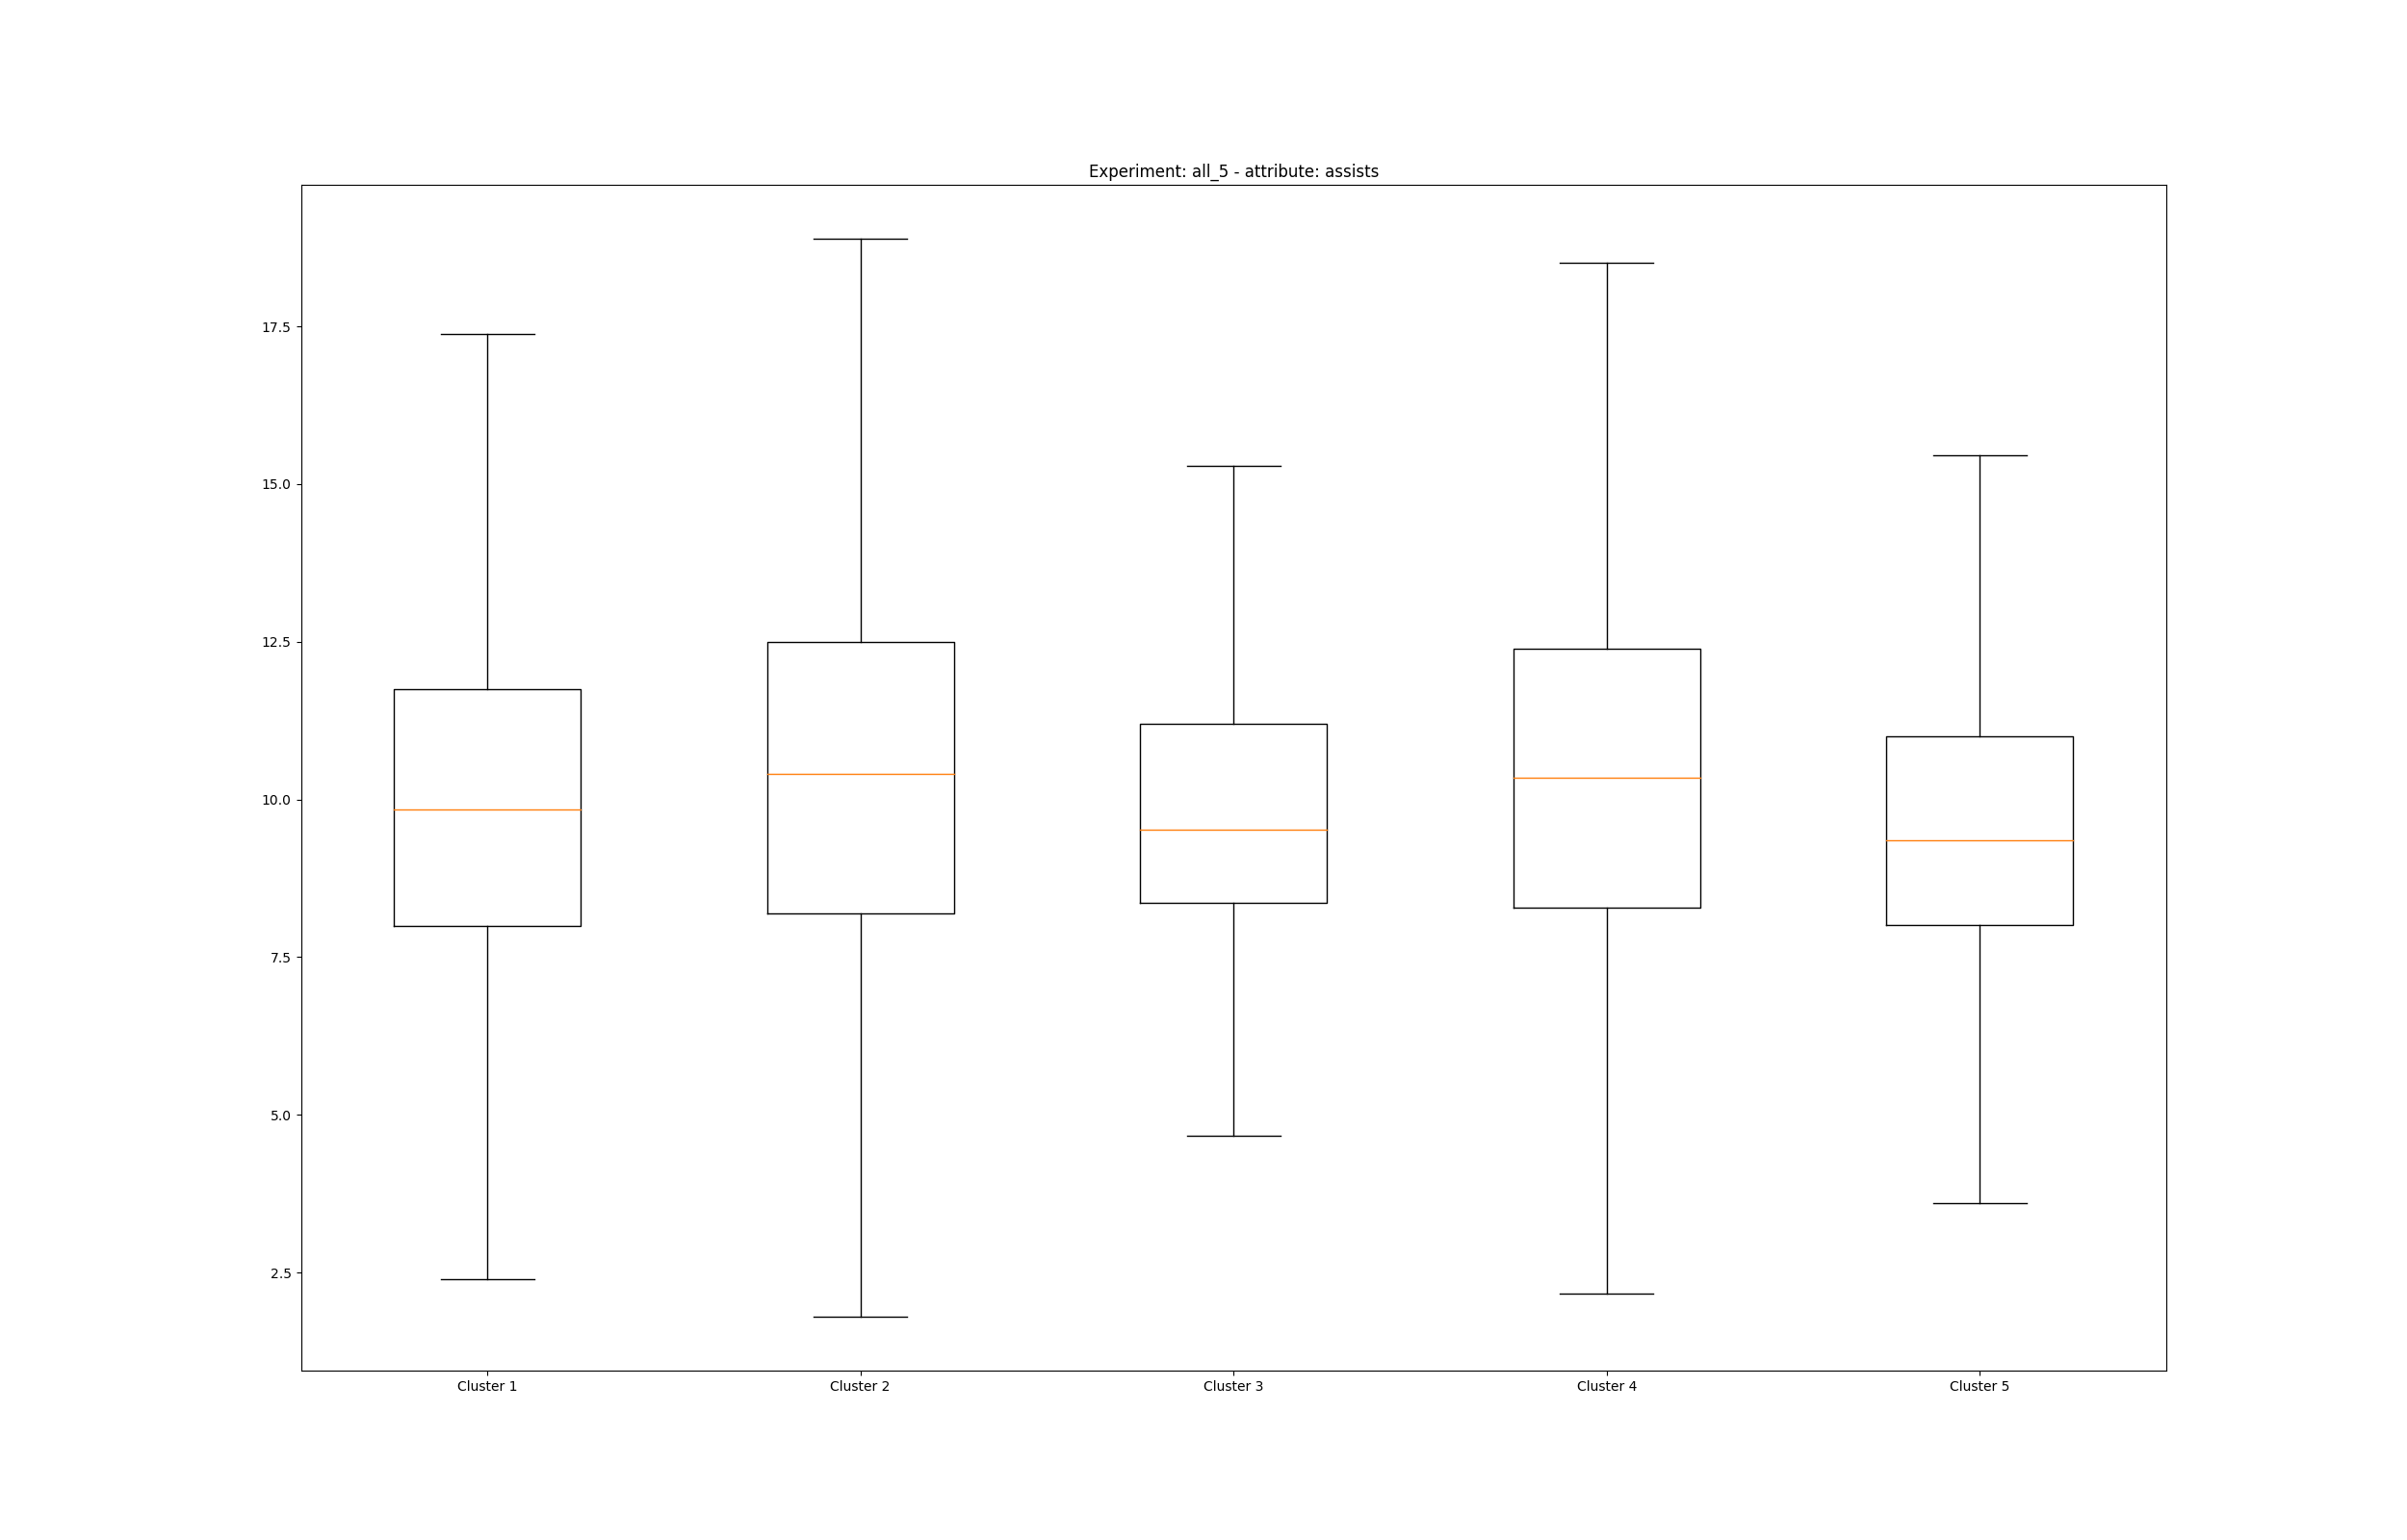

In [9]:
from IPython.display import Image

Image(filename='data/all_5_assists.png') 

- ##### Plot do atributo last hits com k = 5, considerando o experimento all

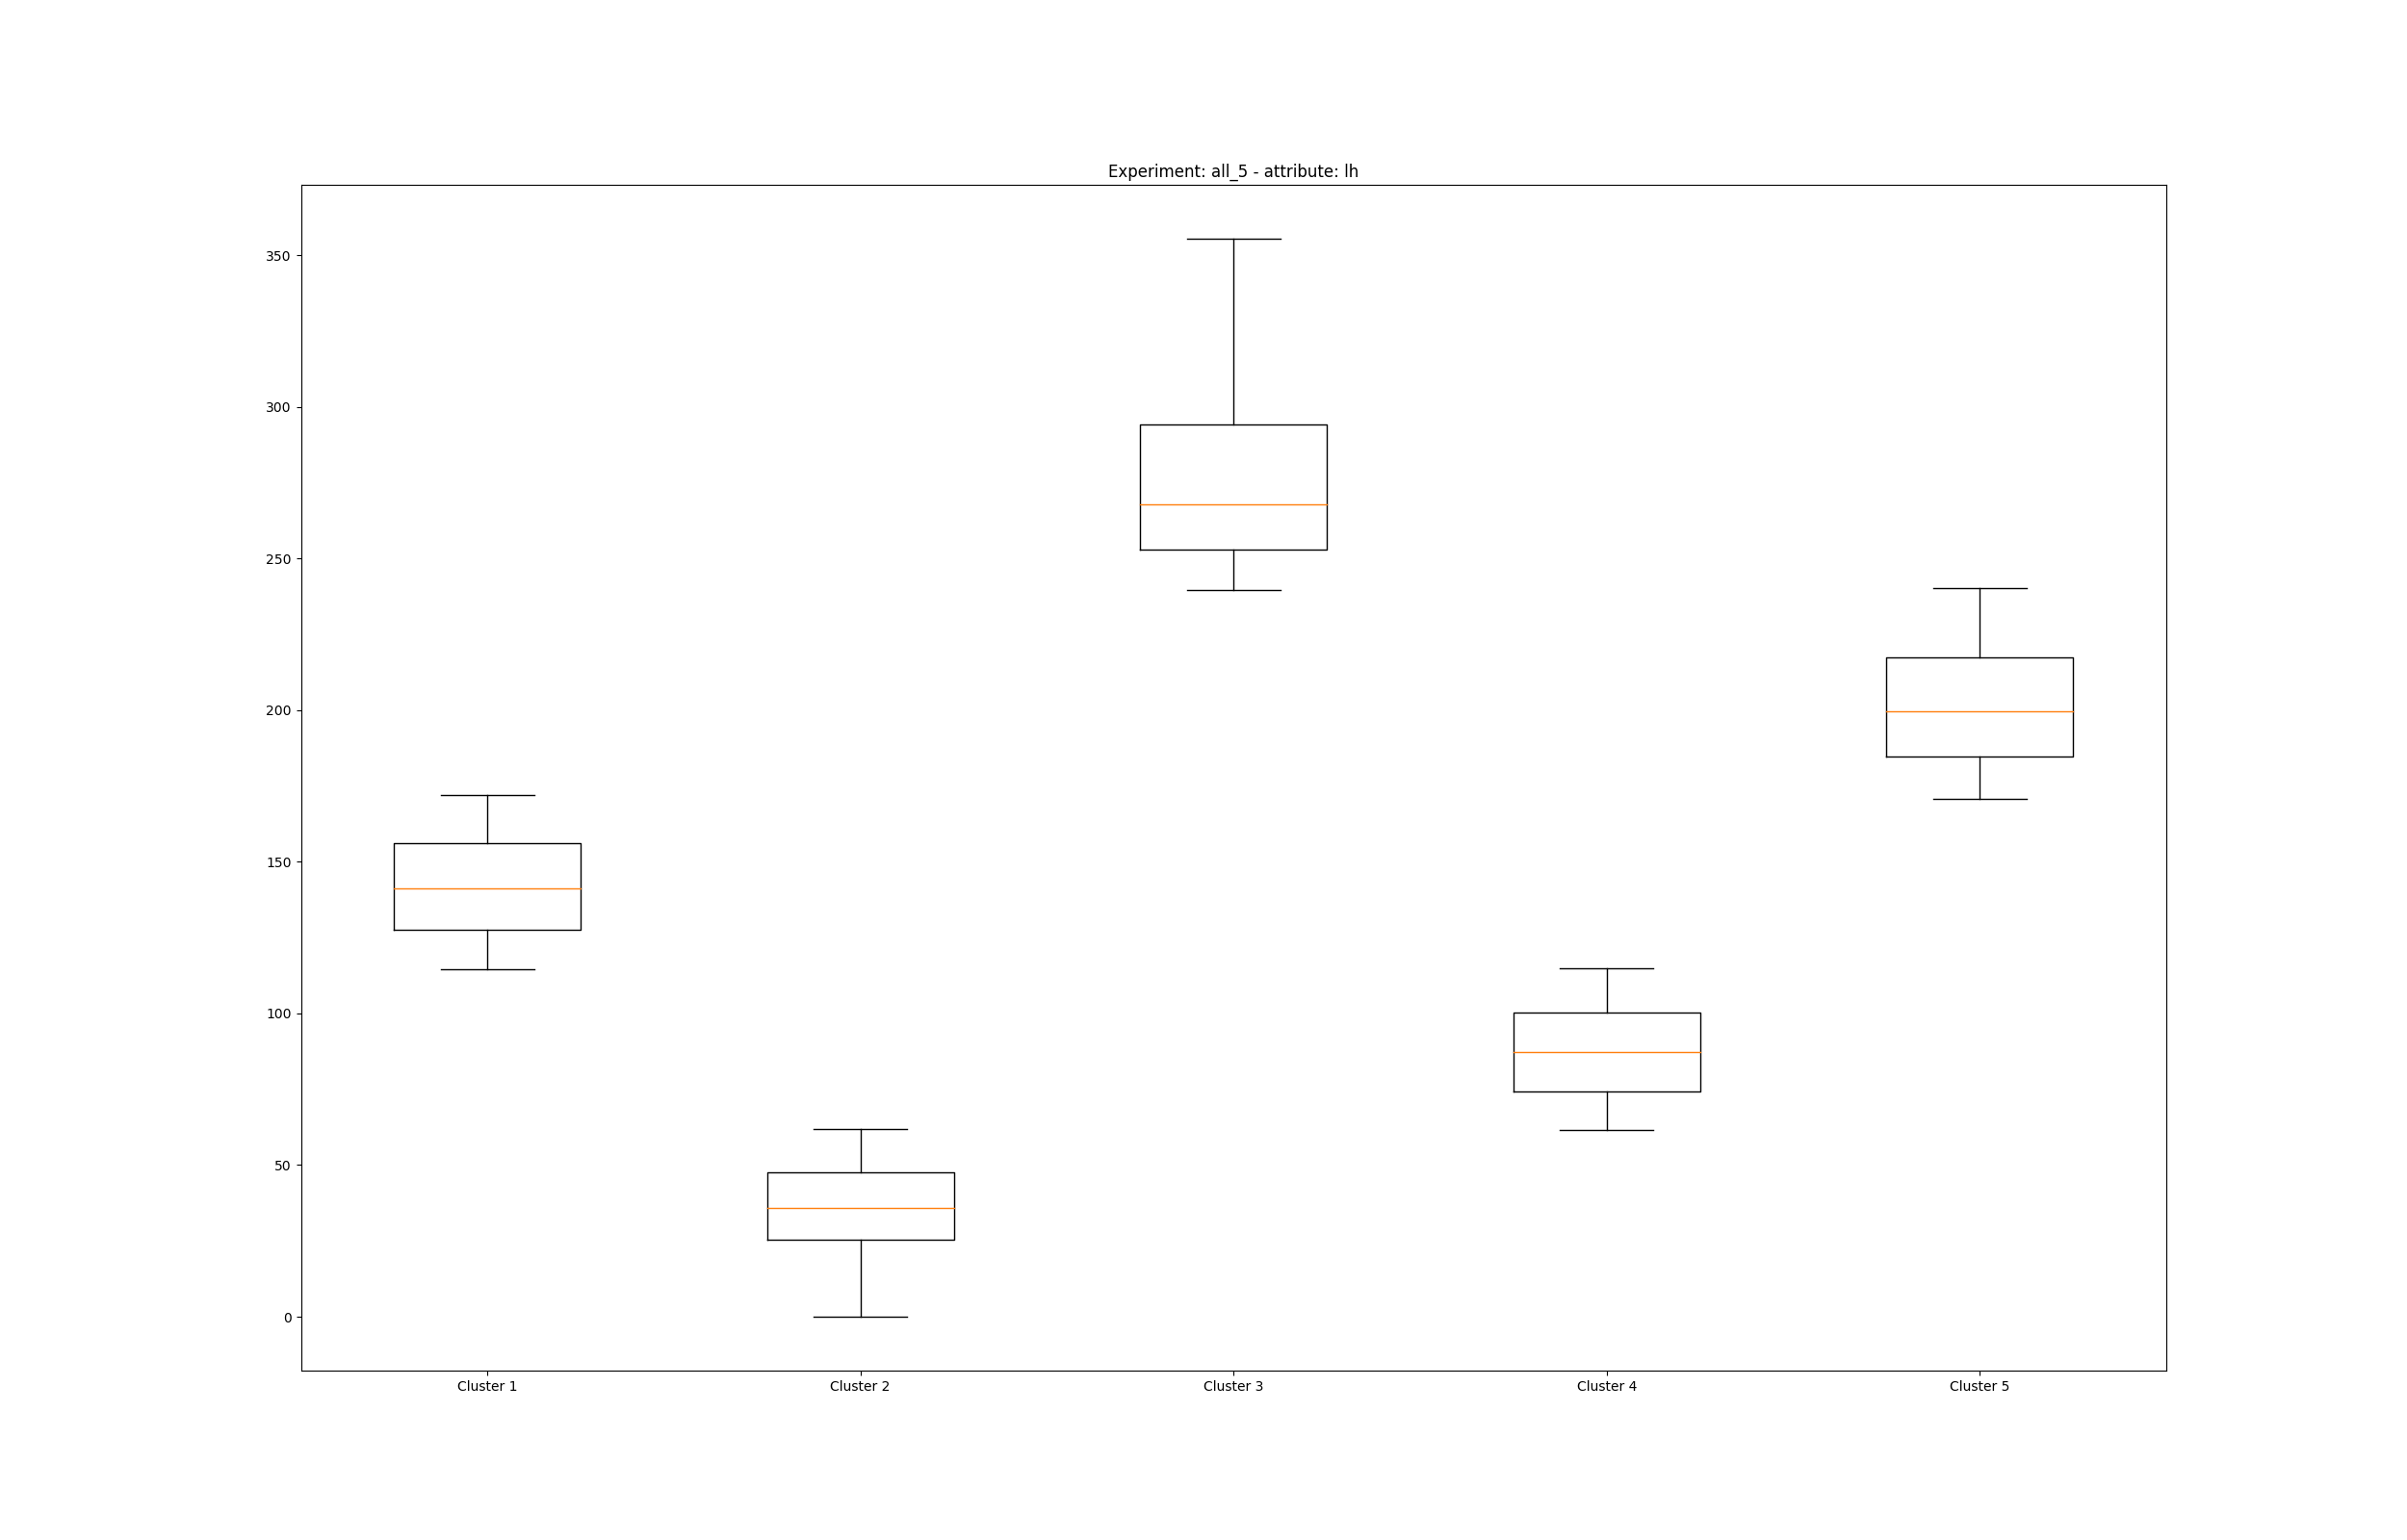

In [10]:
Image(filename='data/all_5_lh.png') 

- Depois de uma análise dos bloxplot's, resolvemos rodar alguns experimentos. São eles: 

| Nome do experimento 	|                          Atributos utilizados                          	|
|:-------------------:	|:----------------------------------------------------------------------:	|
|         kdlh        	|                         "kills", "denies", "lh"                        	|
|       everyone      	| "kills", "deaths", "assists", "denies", "gpm", "hd", "hh", "lh", "xpm" 	|
|        5best        	|                    "kills", "gpm", "hd", "lh", "xpm"                   	|
|        2best        	|                              "kills", "hd"                             	|
|         best        	|                                  "hd"                                  	|
|         wtf         	|                       "kills", "gpm", "lh", "xpm"                      	|
|         wohd        	|     "kills","deaths", "assists", "denies", "gpm", "hh", "lh", "xpm"    	|

- A poda de outliers nesses experimentos será feita de uma outra forma. Se um jogador é outlier em um atributo, consideramos ele como outlier na base inteira

- ##### Plot da inércia das classificações

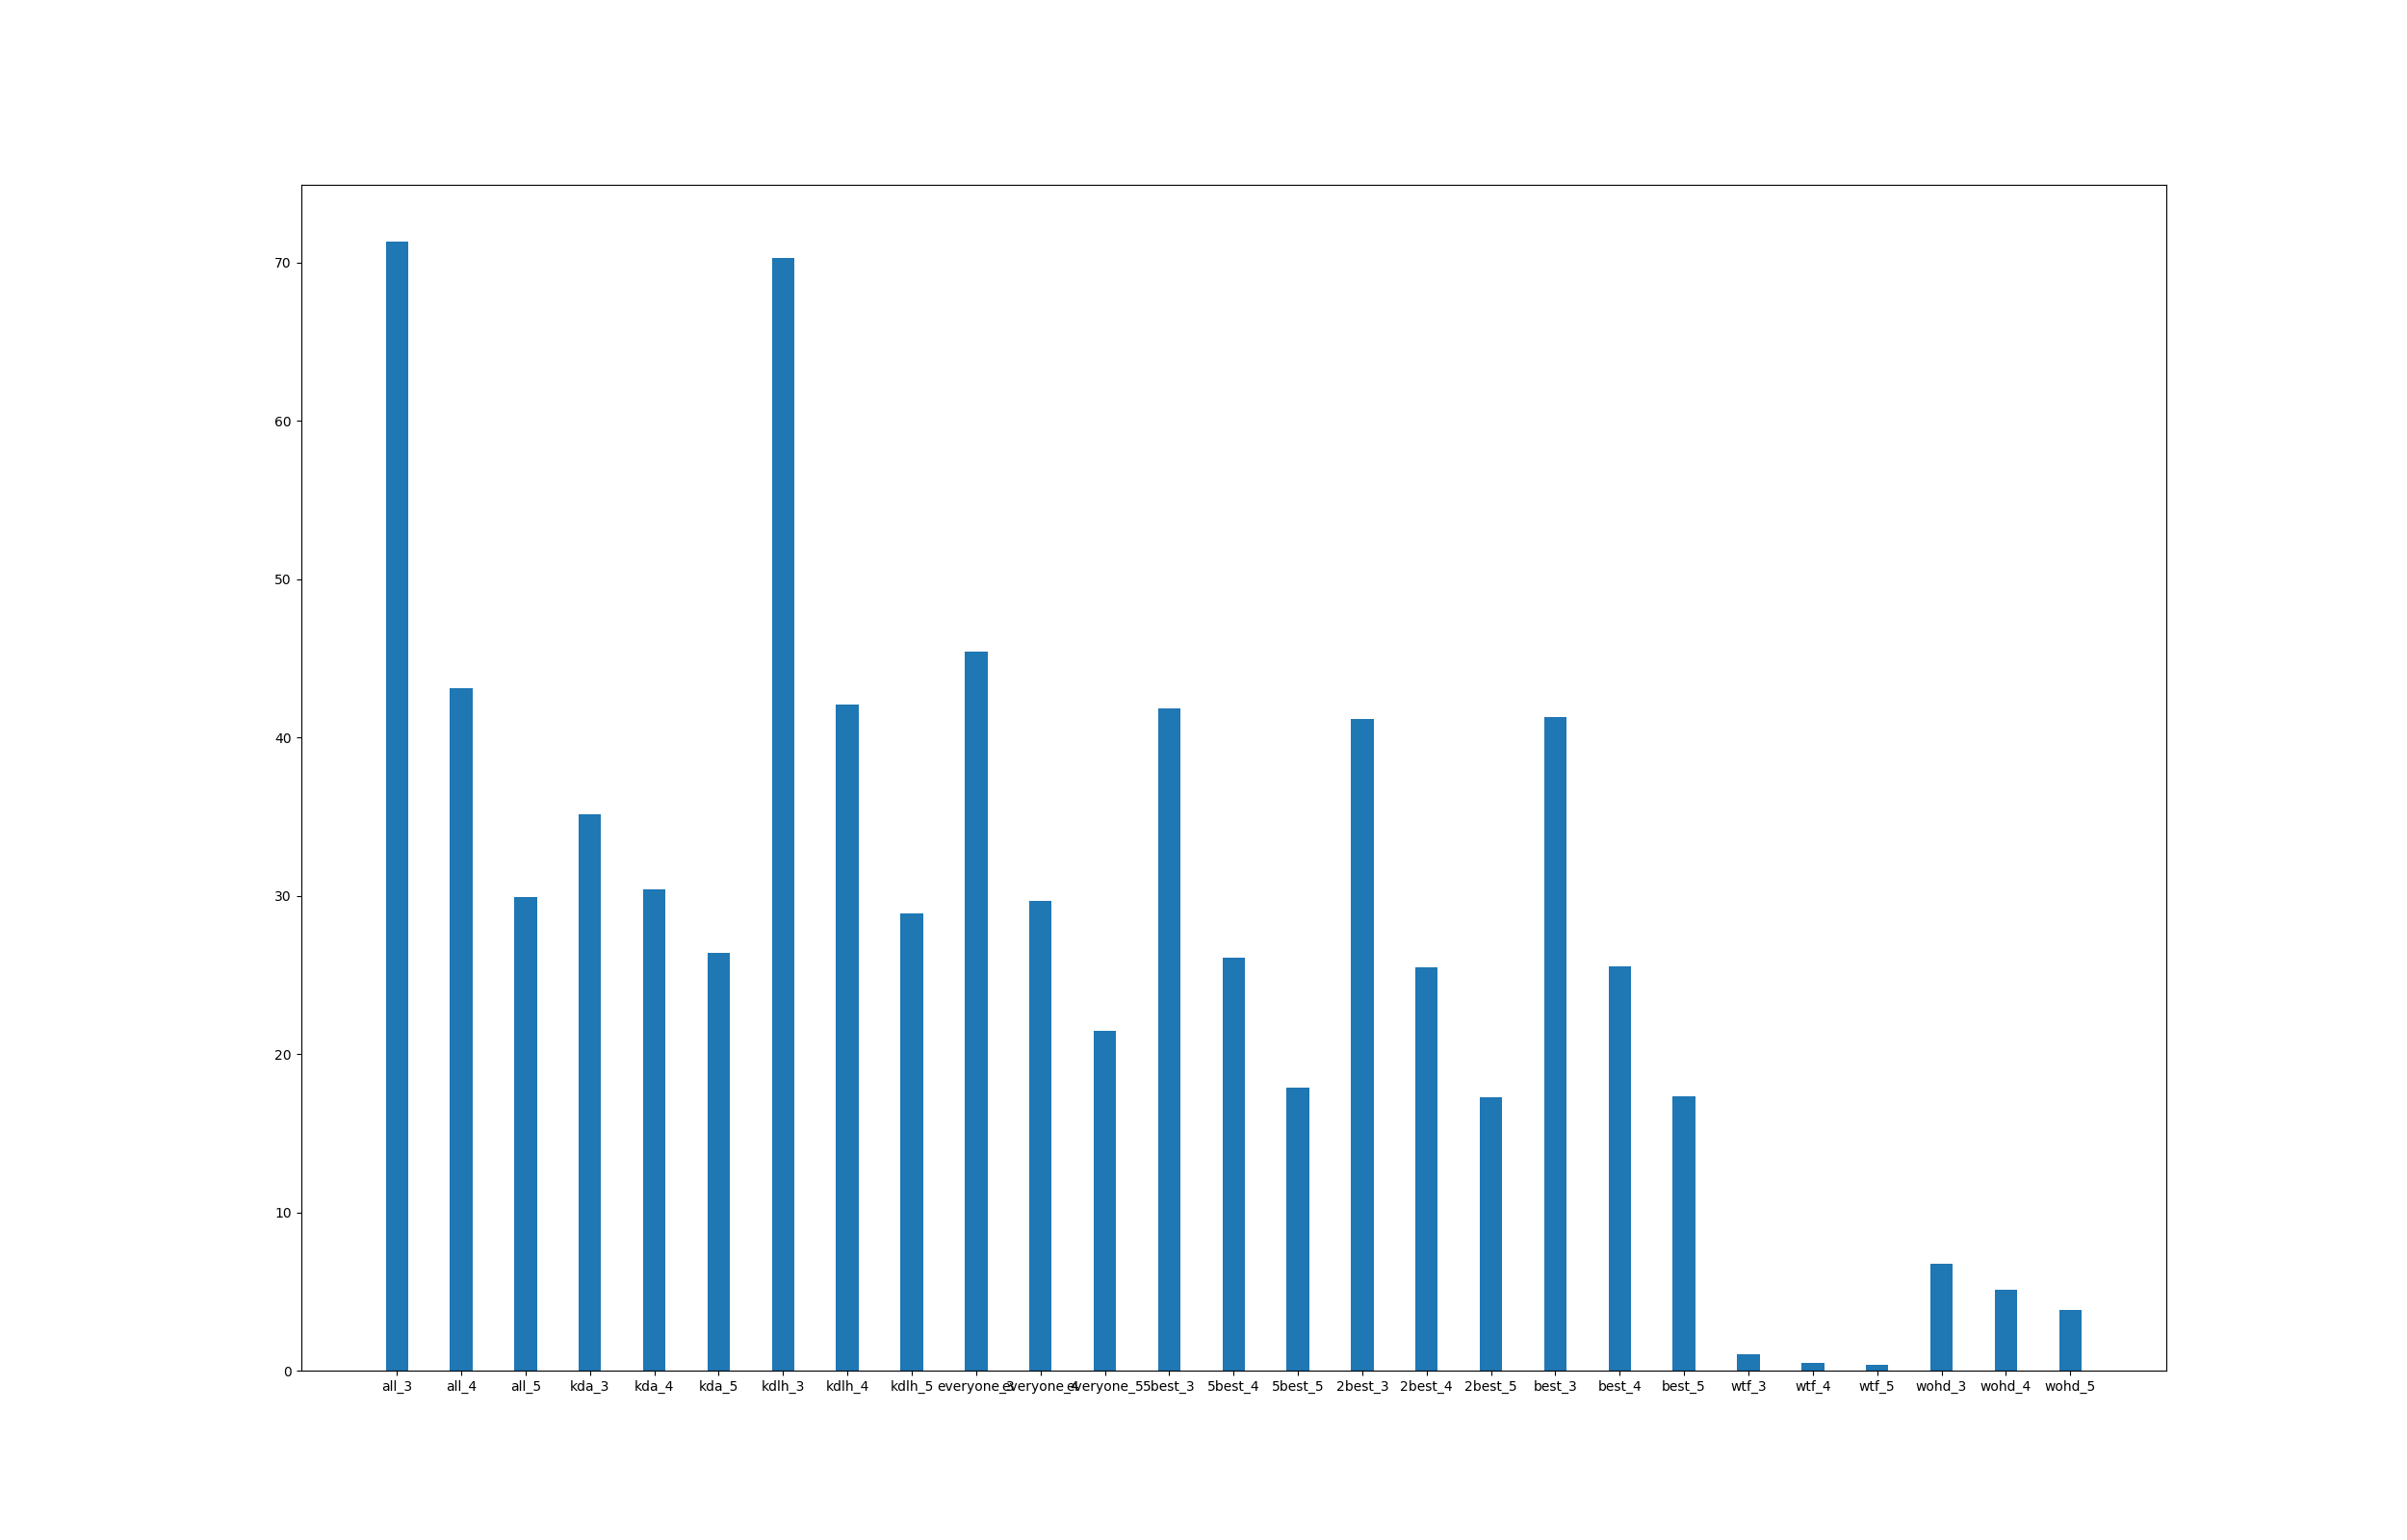

In [11]:
Image(filename='data/inertia.png') 

- ##### Plot do atributo hd com $k = 5$, considerando o experimento best

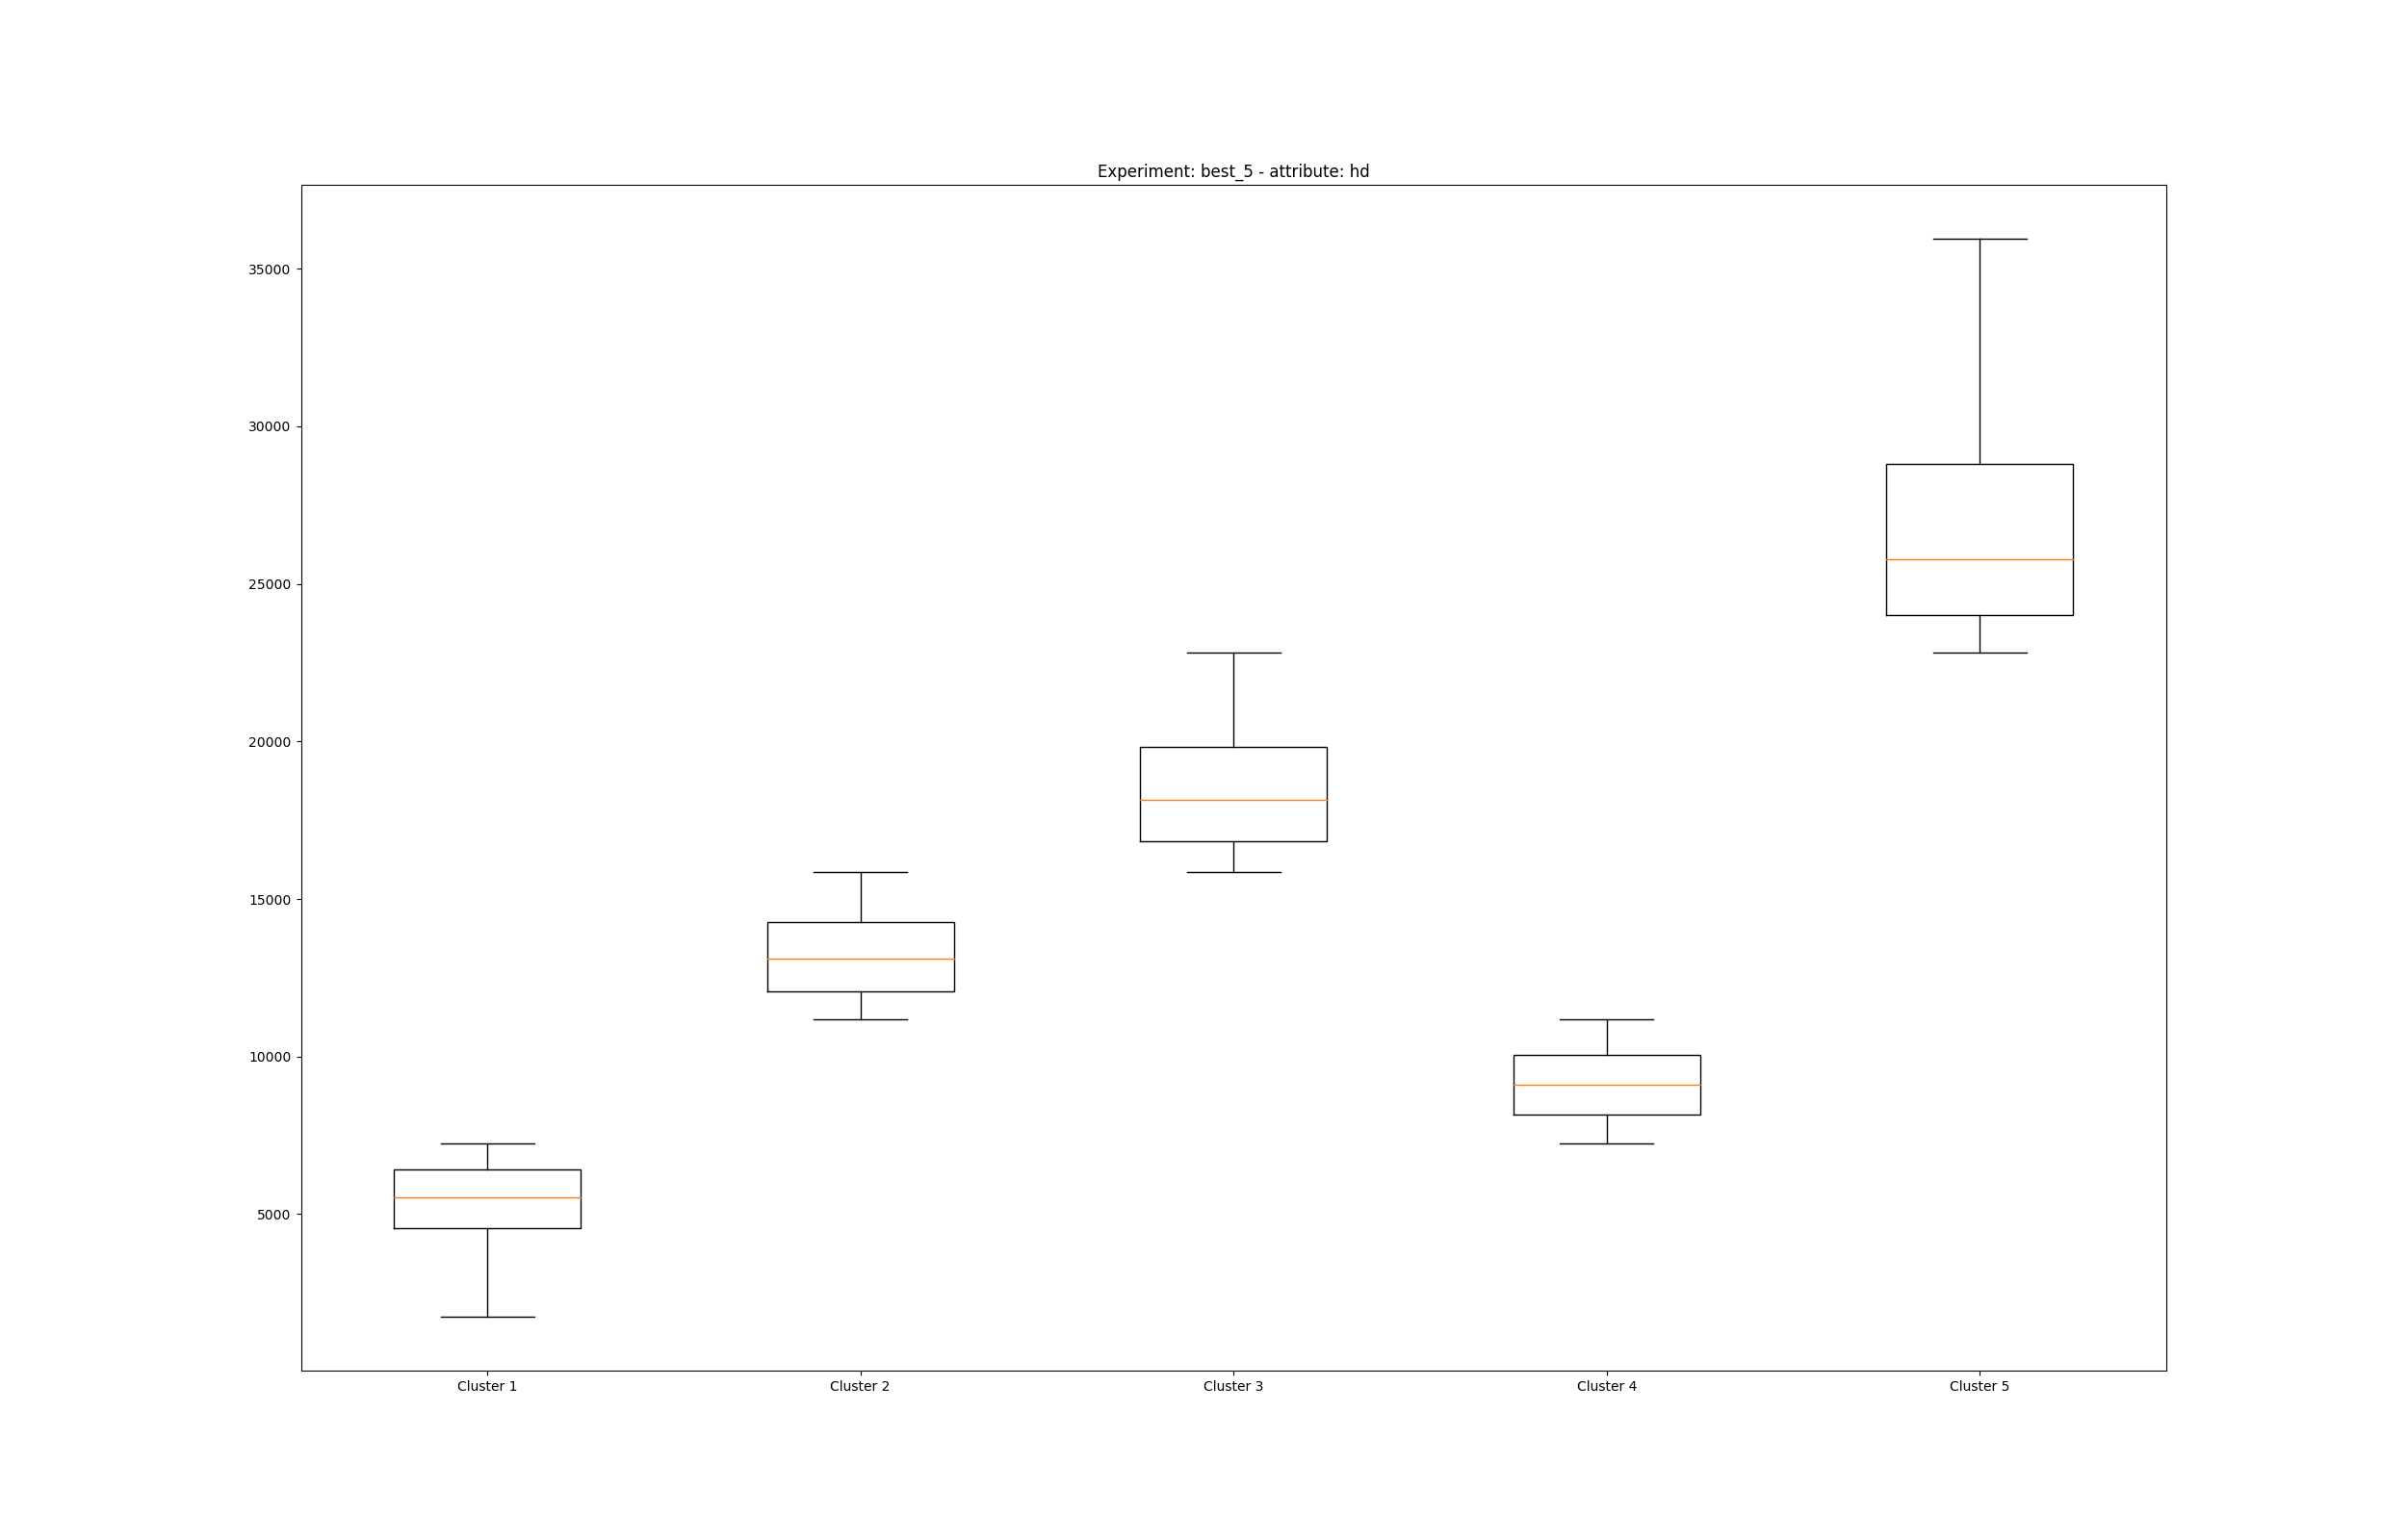

In [12]:
Image(filename='data/best_5_hd.png') 

- Os resultados preliminares não foram muito animadores. Pelo que parece, o atributo hd descreve a base inteira, já que a  classificação best teve a menor inércia com uma boa distribuição entre os clusters. Wtf e wohd tiveram uma inércia ainda menor, mas existiam clusteres vazios ou quase vazios, o que torna ruim a classificação.
- Outra coisa que concluimos é que a poda por outlier não interfere muito no resultado, então obtamos por não fazê-la nos próximos experimentos